# 1. Подготовка

Подлкючим необходимые модули:

In [1]:
import pandas as pd
import numpy as np
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

Загрузим данные и посмотрим на них:

In [2]:
# этот блок добавлен, потому что выполнял на ПК Windows, чтобы не ошибиться и не переписывать для работы на серере
path_data = os.path.normpath('datasets/taxi.csv')
data = pd.read_csv(path_data)

In [3]:
data.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Приведём признак даты и времени к формату *datetime64*:

In [5]:
data['datetime']= pd.to_datetime(data['datetime'], format='%Y-%m-%d %H:%M:%S')

Сделаем время индексом:

In [6]:
data = data.set_index('datetime')

In [7]:
if data.index.is_monotonic:
    print("Данные в хронологическом порядке")

Данные в хронологическом порядке


In [8]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


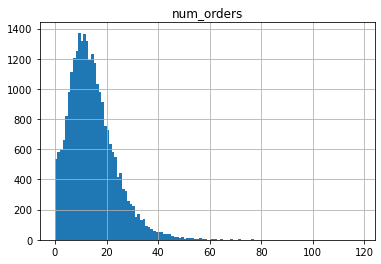

In [9]:
data.hist(bins=range(data['num_orders'].min(), data['num_orders'].max()));

Данные не имеют значительных выбросов и аномалий и в дополнительной предобработке не нуждаются.

Выполним ресемплирование данных по одному часу

In [10]:
data = data.resample('1H').sum()

# 2. Анализ

Добавим к данным календарные признаки (время, день недели). 

In [11]:
data['dayofweek'] = data.index.dayofweek
data['hour'] = data.index.hour
data.head()

,num_orders,dayofweek,hour
datetime,,,
2018-03-01 00:00:00,124,3,0
2018-03-01 01:00:00,85,3,1
2018-03-01 02:00:00,71,3,2
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,3,4


Напишем функцию для добавления признаков:

In [12]:
def make_features(data, max_lag, rolling_mean_size, day):
    if day==True:
        data['day'] = data.index.day
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data

Построим график количества заказов

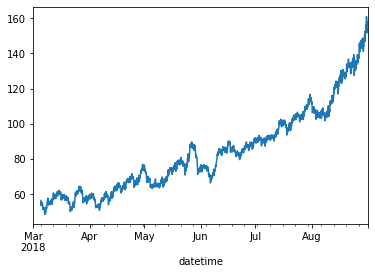

In [13]:
data['num_orders'].rolling(100).mean().plot();

Видно, что от марта к сентябрю количество заказов такси увеличивается. К сожалению, данные предоставлены за слишком короткий промежуток времени, по этому нельзя сделать какие-либо выводы о сезонности изменений. Или глобальном увеличении поездок на такси

In [14]:
decomposed = seasonal_decompose(data['num_orders'])

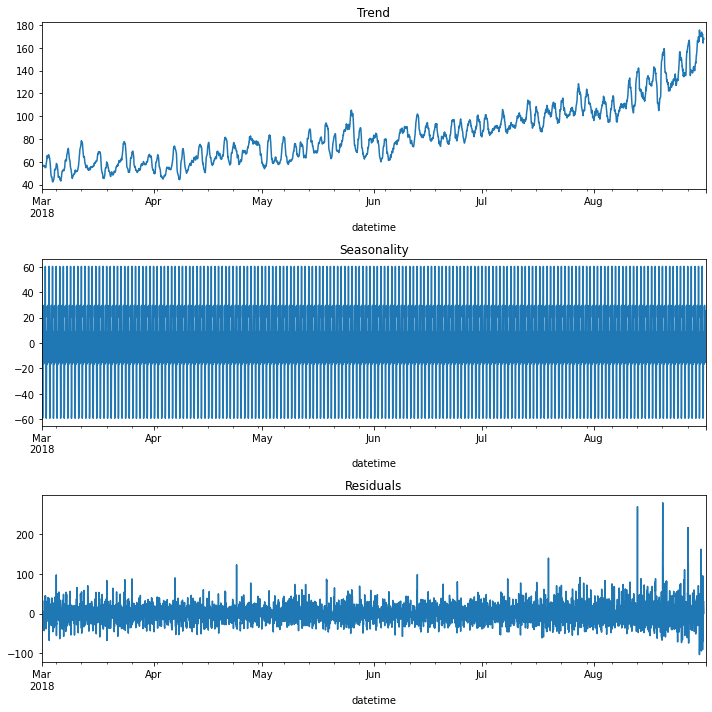

In [15]:
plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

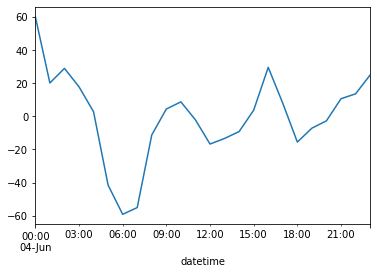

In [16]:
decomposed.seasonal['2018-06-04':'2018-06-04'].plot(ax=plt.gca());

На графике выше видно изменение количества вызовов в такси в течение дня

Посмотрим как меняется количество заказов такси в течение недели:

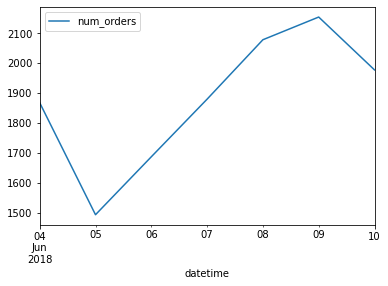

In [17]:
data.resample('1D').sum().pivot_table(index='datetime', values='num_orders', aggfunc='sum')['2018-06-04':'2018-06-10'].plot();

Наибольшее количество заказов приходится на конец недели. Особенно пятнцу-субботу, что вполне ожидаемо

# 3. Обучение

Добавим отстающие значения и скользящее среднее. Но сделаем это так, чтобы количество отстающих значений и окно скользящего среднего были гиперпараметрами. Также число сделаем гиперпараметром. Может быть люди ездят больше на такси в день зарплат? Если модель будет переобучаться - отключим данный признак.

In [19]:
def search_param(data, max_lag, rolling_mean_size, day, model):
    min_rmse = 9999999
    final_model = 0
    final_lag = 0
    final_rolling = 0
    final_day = 0
    for lag in max_lag:
        for rolling in rolling_mean_size:
            for d in day:
                for m in model:
                    data_testing = make_features(data.copy(), lag, rolling, d)
                    data_testing = data_testing.dropna()
                    target = data_testing['num_orders']
                    features = data_testing.drop('num_orders', axis=1)
                    m.fit(features, target)
                    rmse = mean_squared_error(target, m.predict(features))
                    if rmse < min_rmse:
                        min_rmse = rmse
                        final_model = m
                        final_lag = lag
                        final_rolling = rolling
                        final_day = d
    
    print('max_lag={:}, rolling_mean_size={:}, day={:}, model={:} RMSE={:}'.format(final_lag, final_rolling, final_day, final_model, min_rmse**0.5)) 

In [21]:
search_param(data, [i for i in range(1,24)], [i for i in range(1,48)], [False], [LinearRegression(n_jobs=-1)])


max_lag=23, rolling_mean_size=24, day=False, model=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False) RMSE=28.27868879929895


In [22]:
%%time
search_param(data, [i for i in range(1,24)], [i for i in range(1,48)], [False], [CatBoostRegressor(loss_function='RMSE', iterations=100, logging_level='Silent')])

max_lag=22, rolling_mean_size=23, day=False, model=<catboost.core.CatBoostRegressor object at 0x000001D871E224F0> RMSE=15.874009295258652
Wall time: 7min 18s


In [23]:
%%time
search_param(data, [i for i in range(1,24)], [i for i in range(1,48)], [False], [LGBMRegressor(n_jobs=-1, random_state=43)])


max_lag=23, rolling_mean_size=31, day=False, model=LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=43, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0) RMSE=13.731301977015113
Wall time: 2min 18s


Возьмём такие параметры подготовки данных: max_lag=23, rolling_mean_size=31, подготовим данные и протестируем модели градиентного бустинга

In [24]:
data_prepared = make_features(data, 23, 31, False)
data_prepared = data_prepared.dropna()

Разделим данные на обучающую и тестовую выборку размером 10% от исходных данных

In [25]:
train, test = train_test_split(data_prepared, shuffle=False, test_size=0.1)

In [26]:
target_train = train['num_orders']
features_train = train.drop('num_orders', axis=1)

target_test = test['num_orders']
features_test = test.drop('num_orders', axis=1)

In [27]:
model_cat_boost = CatBoostRegressor(loss_function='RMSE', iterations=100, logging_level='Silent')
model_lgbmr = LGBMRegressor(n_jobs=-1, random_state=42)

In [28]:
%%time
model_cat_boost.fit(features_train, target_train)

Wall time: 488 ms


In [29]:
%%time
model_lgbmr.fit(features_train, target_train)

Wall time: 155 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

# 4. Тестирование

In [30]:
mean_squared_error(target_test, model_cat_boost.predict(features_test))**0.5

41.94751717310963

In [31]:
mean_squared_error(target_test, model_lgbmr.predict(features_test))**0.5

41.82297666503804

Добавив такие календарные признаки - часы и день недели, отстающие значения за 23 часа и скользящее среднее за 31 час можно использовать модели градиентного бустинга для предсказания загруженности такси в следующий час с RMSE менее 48.

# Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48